In [ ]:
# installation
! pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=f6be45c74ae8c2948e9d420bc0dac72364d3136d13e8be133f5a485307a0989b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ihbongm/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")
print(hist)

                  Open        High  ...  Dividends  Stock Splits
Date                                ...                         
1986-03-13    0.056001    0.064236  ...        0.0           0.0
1986-03-14    0.061491    0.064785  ...        0.0           0.0
1986-03-17    0.063687    0.065334  ...        0.0           0.0
1986-03-18    0.064785    0.065334  ...        0.0           0.0
1986-03-19    0.063138    0.063687  ...        0.0           0.0
...                ...         ...  ...        ...           ...
2021-11-01  331.359985  331.489990  ...        0.0           0.0
2021-11-02  330.309998  333.450012  ...        0.0           0.0
2021-11-03  333.899994  334.899994  ...        0.0           0.0
2021-11-04  332.890015  336.540009  ...        0.0           0.0
2021-11-05  338.510010  338.790009  ...        0.0           0.0

[8988 rows x 7 columns]


In [ ]:
type(hist)

pandas.core.frame.DataFrame

In [ ]:
hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [ ]:
# we will only use closing price as our target signal, while other prices as additional features if needed
# https://analyzingalpha.com/open-high-low-close-stocks

In [ ]:
# download ticker data from nasdaq, manually extracted 
import urllib.request
url = 'https://gitlab.com/brainekt_ai/us-stock-ticker/-/raw/main/nasdaq_screener_1635374155108.csv'
filename = 'nasdaq_screener_1635374155108.csv'
urllib.request.urlretrieve(url, filename)

('nasdaq_screener_1635374155108.csv',
 <http.client.HTTPMessage at 0x7f2ac7e0ad90>)

In [ ]:
! ls

nasdaq_screener_1635374155108.csv  sample_data


In [ ]:
import pandas as pd

tickers = pd.read_csv("nasdaq_screener_1635374155108.csv")

In [ ]:
tickers.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AACG,ATA Creativity Global American Depositary Shares,$2.28,-0.06,-2.564%,7.153938e+07,China,NaN,75873,Miscellaneous,Service to the Health Industry
1,AACIU,Armada Acquisition Corp. I Unit,$9.95,0.00,0.00%,0.000000e+00,United States,2021.0,3,NaN,NaN
2,AADI,Aadi Bioscience Inc. Common Stock,$27.03,0.12,0.446%,5.640983e+08,United States,NaN,33626,Health Care,Biotechnology: Pharmaceutical Preparations
3,AAL,American Airlines Group Inc. Common Stock,$19.03,-0.36,-1.857%,1.232220e+10,United States,NaN,22076823,Transportation,Air Freight/Delivery Services
4,AAME,Atlantic American Corporation Common Stock,$3.98,-0.10,-2.451%,8.123484e+07,United States,NaN,14868,Finance,Life Insurance


In [ ]:
tickers_ls = list(tickers["Symbol"])

In [ ]:
tickers_ls[:20] # list of all tickers, only showing top 20

['AACG',
 'AACIU',
 'AADI',
 'AAL',
 'AAME',
 'AAOI',
 'AAON',
 'AAPL',
 'AATC',
 'AAWW',
 'ABCB',
 'ABCL',
 'ABCM',
 'ABEO',
 'ABGI',
 'ABIO',
 'ABMD',
 'ABNB',
 'ABOS',
 'ABSI']

company: BANX


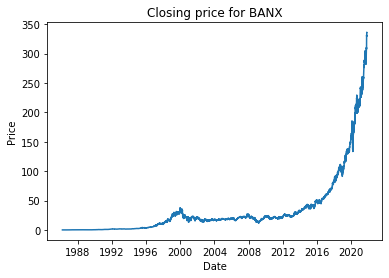

In [ ]:
# choose a random company, plot it's data
import random
import matplotlib.pyplot as plt

comp = random.choice(tickers_ls)
print(f"company: {comp}")

# get data
comp_tick = yf.Ticker("MSFT")

# get historical market data
hist = comp_tick.history(period="max")
plt.plot(hist["Close"])
plt.title(f"Closing price for {comp}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [ ]:
# utils code
# assist

import os
import time

import tqdm
from tqdm import tqdm_notebook

## Data Processing
import pandas as pd
import numpy as np
import matplotlib as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.externals import joblib 


#### DATA CREATION FUNCTIONS ####
def create_data(file_list):
    """
    Utility function to create a dataset from a filelist.
    """
    counter = 1
    df_list = pd.DataFrame()
    for file in file_list:
        if (os.stat(file).st_size != 0):
            df = pd.read_csv(file, sep = ",")
            df['symbol'] = file
            df_list = df_list.append(df)
            print (counter, " out of ", len(file_list))
            counter += 1
    return pd.DataFrame(df_list)


def fetch_data():
    """
    Get the files from the data folder. 
    """
    main_dir = os.getcwd()
    # STOCKS
    os.chdir(main_dir)
    os.chdir("./data/Stocks")
    stock_list = os.listdir()
    stocks = create_data(stock_list)
    #ETFs
    os.chdir(main_dir)
    os.chdir("./data/ETFs")
    etf_list = os.listdir()
    etf = create_data(etf_list)

    return stocks, etf


#### DATA PROCESSING FUNCTIONS ####
def scale_df(data, model_name):
    """
    This class takes in a pandas dataframe and generates 
    the normalized version of it
    """
    # scales the data
    scaler = MinMaxScaler()
    df = scaler.fit_transform(data)
    
    return df, scaler


def generate_ta(data):
    """
    Runs ta on a dataset and saves to csv.
    """
    # converts data into ta dataframe
    df = add_all_ta_features(data, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df.to_csv("../data/df_ta.csv")
    

def build_window(df, look_back, n_features):
    """
    Builds sliding windows to shift the batch by 1 step at a time
    """
    x_train = [] # This list contain the sequences to predict when training
    y_train = [] # This list contain the next value of the sequences when training

    for i in range(look_back, df.shape[0]):
        x_train.append(df[i-look_back:i,0:n_features].tolist()) # ,0 used in order to return the values only
        y_train.append(df[i,0].tolist()) # tolist() converts np array to simple array
   
    # Converting arrays from lists to np arrays. 
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Rounding numbers to speed up training.
    x_train = np.round(x_train, 5)
    y_train = np.round(y_train, 5)

    return x_train, y_train


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by the batch size
    """

    no_of_rows_drop = mat.shape[0] % batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

#### FINAL PIPELINE FUNCTION ####
def preproc_pipeline(data, name):
    """
    The preprocessing pipeline takes in a csv of processed data and creates
    the training, validation, and test sets
    """
    # Scale values
    data, scaler = scale_df(data, name)
    # Split
    train_set, testval_set = train_test_split(data, train_size=0.6, test_size=0.4, shuffle=False)
    validation_set, test_set = train_test_split(testval_set, train_size=0.7, test_size=0.3, shuffle=False)
    
    return train_set, validation_set, test_set, scaler


def model_preproc_pipeline(data, look_back, batch_size, n_features):
    """
    preprocesses data for LSTM input
    """
    x_train, y_train = build_window(data, look_back, n_features)

    x_train = trim_dataset(x_train, batch_size)
    y_train = trim_dataset(y_train, batch_size)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    return x_train, y_train
    

def generate_dataset():
        stocks, etf = create_data(".")
        data = pd.concat([stocks, etf])
        generate_ta(data)
        # we have to read file
        data = pd.read_csv("./df_ta.csv")

In [ ]:
from tensorflow import keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import CSVLogger

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


def baseline_lstm_model(n_features, batch_size, look_back):
    """
    Returns a keras LSTM model. Our architecture will be kept 
    in this method.
    """
    model = Sequential()

    model.add(LSTM(units = 64, return_sequences = True, input_shape = (look_back, n_features)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 512, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model


def train_model(model, x_train, y_train, epochs, batch_size, lr):
    """
    Takes a training dataset and a model and returns a trained model 
    after ts timesteps.
    """
    model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size)

    return model

In [ ]:
# Defining hyper parameters
TIME_STEPS = 30
BATCH_SIZE = 128
N_FEATURES = 1
lr = 0.0001 # learning rate
EPOCHS = 5

In [ ]:
regressor = baseline_lstm_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

In [ ]:
regressor.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 30, 64)            16896     
_________________________________________________________________
dropout_119 (Dropout)        (None, 30, 64)            0         
_________________________________________________________________
lstm_120 (LSTM)              (None, 30, 128)           98816     
_________________________________________________________________
dropout_120 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 30, 256)           394240    
_________________________________________________________________
dropout_121 (Dropout)        (None, 30, 256)           0         
_________________________________________________________________
lstm_122 (LSTM)              (None, 30, 512)         

In [ ]:
# Prediction model 1 based on George V Jose
from sklearn.metrics import mean_squared_error
def predict(data, num_prediction):
    # Scaling data
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    # Looking at last TIME_STEPS value
    prediction_list = scaled[-TIME_STEPS:]
    
    for _ in range(num_prediction):
        # Looking at last TIME_STEPS value (1 of our batch)
        x = prediction_list[-TIME_STEPS:]
        x = np.array(x)
        
        # 1 batch with TIME_STEPS and 1 feature
        x = x.reshape((1, TIME_STEPS, 1))
        
        # prediction
        print("predicting batch ", x)
        output = model.predict(x)[0][0]
        
        # Appends prediction results back into 
        prediction_list = np.append(prediction_list, output)
        
    prediction_list = prediction_list[TIME_STEPS - 1:]
    
    # Reverse the scaling
    prediction_list = prediction_list.reshape(num_prediction+1, 1)
    prediction_list = scaler.inverse_transform(prediction_list)
    
    return prediction_list

# Prediction model 2 based on Ravindra Compella
def moving_test_window_preds(data, num_predictions, TIME_STEPS, model):
    prediction_list = []
    
    # Scaling data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    moving_test_window = data[-TIME_STEPS:]
    moving_test_window = np.array(moving_test_window)
    
    # Scaling data
    # scaler = MinMaxScaler()
    # moving_test_window = scaler.fit_transform(moving_test_window)
    
    # Reshaping data
    moving_test_window = moving_test_window.reshape((1, TIME_STEPS, 1))
    
    for i in range(num_predictions):
        # print("predicting batch ", moving_test_window)
        preds_one_step = model.predict(moving_test_window)
        prediction_list.append(preds_one_step[0,0])
        preds_one_step = preds_one_step.reshape(1,1,1)
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1)
        
    prediction_list = np.array(prediction_list)
    prediction_list = prediction_list.reshape(num_predictions, 1)
    prediction_list = scaler.inverse_transform(prediction_list)
    
    return prediction_list

In [ ]:
top_companies = ['AMZN', 'AAPL', 'NFLX', 'GOOG', 'MSFT', 'GOOGL', 'TSLA', 'CSCO', 'COST', 'FB']

In [ ]:
for i in range(len(top_companies)):
    comp = top_companies[i]
    comp_tick = yf.Ticker(comp)
    # get historical market data
    hist = comp_tick.history(period="max")
    print(f"{comp}: {len(hist) * 0.4 * 0.3 // 2}")

AMZN: 369.0
AAPL: 618.0
NFLX: 294.0
GOOG: 260.0
MSFT: 539.0
GOOGL: 260.0
TSLA: 171.0
CSCO: 479.0
COST: 534.0
FB: 143.0


In [ ]:
# Defining hyper parameters
TIME_STEPS = 100
BATCH_SIZE = 128
N_FEATURES = 1
lr = 0.0001 # learning rate
EPOCHS = 5
# result generation

for i in range(len(top_companies)):
    comp = top_companies[i]
    comp_tick = yf.Ticker(comp)
    # get historical market data
    hist = comp_tick.history(period="max")
    # train data
    # we only use closing price
    data = hist.iloc[:,1:2]
    train, valid, test, scalar = preproc_pipeline(data, False)
    # Create windows, trim windows, and reshape for LSTM input
    x_train, y_train = model_preproc_pipeline(train, TIME_STEPS, BATCH_SIZE, N_FEATURES)

    regressor = baseline_lstm_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

    # train model
    # Training the model
    regressor = train_model(regressor, x_train, y_train, EPOCHS, BATCH_SIZE, lr)

    # Preparing test and validation sets
    df_test = trim_dataset(test, BATCH_SIZE)
    df_val, df_testing = np.split(df_test, 2)

    n_samples = len(df_testing)

    unseen_predictions = moving_test_window_preds(df_val, n_samples, TIME_STEPS, regressor)

    # Evaluating model for unseen data
    mse = mean_squared_error(df_testing[:n_samples], unseen_predictions[:n_samples])
    n_mse = mse / (df_testing[:n_samples]).mean()
    print(f"comp: {comp} mse: {mse} norm_mse: {n_mse}")

Epoch 1/5
28/28 [==============================] - 17s 282ms/step - loss: 2.8646e-04
Epoch 2/5
28/28 [==============================] - 8s 279ms/step - loss: 1.3426e-04
Epoch 3/5
28/28 [==============================] - 8s 279ms/step - loss: 2.5507e-05
Epoch 4/5
28/28 [==============================] - 8s 278ms/step - loss: 1.2906e-05
Epoch 5/5
28/28 [==============================] - 8s 278ms/step - loss: 1.1206e-05
comp: AMZN mse: 0.16148725352399126 norm_mse: 0.20177705508896324
Epoch 1/5
47/47 [==============================] - 23s 281ms/step - loss: 9.7539e-05
Epoch 2/5
47/47 [==============================] - 13s 279ms/step - loss: 2.6217e-06
Epoch 3/5
47/47 [==============================] - 13s 278ms/step - loss: 2.2641e-06
Epoch 4/5
47/47 [==============================] - 13s 278ms/step - loss: 2.0595e-06
Epoch 5/5
47/47 [==============================] - 13s 278ms/step - loss: 2.0334e-06
comp: AAPL mse: 0.20415483832183037 norm_mse: 0.35877240162690377
Epoch 1/5
22/22 [=====

In [ ]:
from tensorflow.keras.layers import LSTM, GRU
def baseline_gru_model(n_features, batch_size, look_back):
    """
    Returns a keras LSTM model. Our architecture will be kept 
    in this method.
    """
    model = Sequential()

    model.add(GRU(units = 64, return_sequences = True, input_shape = (look_back, n_features)))
    model.add(Dropout(0.2))

    model.add(GRU(units = 128, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 512, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 128, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 64))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [ ]:
regressor = baseline_gru_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

In [ ]:
regressor.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 64)           12864     
_________________________________________________________________
dropout_280 (Dropout)        (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 128)          74496     
_________________________________________________________________
dropout_281 (Dropout)        (None, 100, 128)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 256)          296448    
_________________________________________________________________
dropout_282 (Dropout)        (None, 100, 256)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 512)        

In [ ]:
# Defining hyper parameters
TIME_STEPS = 100
BATCH_SIZE = 128
N_FEATURES = 1
lr = 0.0001 # learning rate
EPOCHS = 5
# result generation

for i in range(len(top_companies)):
    comp = top_companies[i]
    comp_tick = yf.Ticker(comp)
    # get historical market data
    hist = comp_tick.history(period="max")
    # train data
    # we only use closing price
    data = hist.iloc[:,1:2]
    train, valid, test, scalar = preproc_pipeline(data, False)
    # Create windows, trim windows, and reshape for LSTM input
    x_train, y_train = model_preproc_pipeline(train, TIME_STEPS, BATCH_SIZE, N_FEATURES)

    regressor = baseline_gru_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

    # train model
    # Training the model
    regressor = train_model(regressor, x_train, y_train, EPOCHS, BATCH_SIZE, lr)

    # Preparing test and validation sets
    df_test = trim_dataset(test, BATCH_SIZE)
    df_val, df_testing = np.split(df_test, 2)

    n_samples = len(df_testing)

    unseen_predictions = moving_test_window_preds(df_val, n_samples, TIME_STEPS, regressor)

    # Evaluating model for unseen data
    mse = mean_squared_error(df_testing[:n_samples], unseen_predictions[:n_samples])
    n_mse = mse / (df_testing[:n_samples]).mean()
    print(f"comp: {comp} mse: {mse} norm_mse: {n_mse}")

Epoch 1/5
28/28 [==============================] - 16s 257ms/step - loss: 8.6987e-04
Epoch 2/5
28/28 [==============================] - 7s 253ms/step - loss: 1.5475e-04
Epoch 3/5
28/28 [==============================] - 7s 254ms/step - loss: 2.7175e-05
Epoch 4/5
28/28 [==============================] - 7s 254ms/step - loss: 1.1781e-05
Epoch 5/5
28/28 [==============================] - 7s 253ms/step - loss: 9.9142e-06
comp: AMZN mse: 0.13675016089688813 norm_mse: 0.17086825211636059
Epoch 1/5
47/47 [==============================] - 21s 254ms/step - loss: 3.4384e-04
Epoch 2/5
47/47 [==============================] - 12s 254ms/step - loss: 5.3098e-06
Epoch 3/5
47/47 [==============================] - 12s 252ms/step - loss: 3.7586e-06
Epoch 4/5
47/47 [==============================] - 12s 253ms/step - loss: 3.2913e-06
Epoch 5/5
47/47 [==============================] - 12s 252ms/step - loss: 3.0278e-06
comp: AAPL mse: 0.20410848672142076 norm_mse: 0.3586909446121504
Epoch 1/5
22/22 [======

In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
def baseline_gru_model(n_features, batch_size, look_back):
    """
    Returns a keras LSTM model. Our architecture will be kept 
    in this method.
    """
    model = Sequential()

    model.add(Bidirectional(GRU(units = 64, return_sequences = True, input_shape = (look_back, n_features))))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units = 128, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units = 256, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units = 512, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units = 256, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units = 128, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(GRU(units = 64)))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [ ]:
regressor = baseline_gru_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)
regressor.build((None, TIME_STEPS, 1))

In [ ]:
regressor.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 100, 128)          25728     
_________________________________________________________________
dropout_378 (Dropout)        (None, 100, 128)          0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 100, 256)          198144    
_________________________________________________________________
dropout_379 (Dropout)        (None, 100, 256)          0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 100, 512)          789504    
_________________________________________________________________
dropout_380 (Dropout)        (None, 100, 512)          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 100, 1024)       

In [ ]:
# Defining hyper parameters
TIME_STEPS = 100
BATCH_SIZE = 128
N_FEATURES = 1
lr = 0.0001 # learning rate
EPOCHS = 5
# result generation

for i in range(len(top_companies)):
    comp = top_companies[i]
    comp_tick = yf.Ticker(comp)
    # get historical market data
    hist = comp_tick.history(period="max")
    # train data
    # we only use closing price
    data = hist.iloc[:,1:2]
    train, valid, test, scalar = preproc_pipeline(data, False)
    # Create windows, trim windows, and reshape for LSTM input
    x_train, y_train = model_preproc_pipeline(train, TIME_STEPS, BATCH_SIZE, N_FEATURES)

    regressor = baseline_gru_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

    # train model
    # Training the model
    regressor = train_model(regressor, x_train, y_train, EPOCHS, BATCH_SIZE, lr)

    # Preparing test and validation sets
    df_test = trim_dataset(test, BATCH_SIZE)
    df_val, df_testing = np.split(df_test, 2)

    n_samples = len(df_testing)

    unseen_predictions = moving_test_window_preds(df_val, n_samples, TIME_STEPS, regressor)

    # Evaluating model for unseen data
    mse = mean_squared_error(df_testing[:n_samples], unseen_predictions[:n_samples])
    n_mse = mse / (df_testing[:n_samples]).mean()
    print(f"comp: {comp} mse: {mse} norm_mse: {n_mse}")

Epoch 1/5
28/28 [==============================] - 38s 601ms/step - loss: 0.0013
Epoch 2/5
28/28 [==============================] - 17s 600ms/step - loss: 3.6660e-05
Epoch 3/5
28/28 [==============================] - 17s 599ms/step - loss: 1.5451e-05
Epoch 4/5
28/28 [==============================] - 17s 598ms/step - loss: 1.2834e-05
Epoch 5/5
28/28 [==============================] - 17s 598ms/step - loss: 1.0963e-05
comp: AMZN mse: 0.12736568855118652 norm_mse: 0.15914242761840314
Epoch 1/5
47/47 [==============================] - 50s 602ms/step - loss: 8.4289e-04
Epoch 2/5
47/47 [==============================] - 28s 598ms/step - loss: 1.0919e-05
Epoch 3/5
47/47 [==============================] - 28s 598ms/step - loss: 8.6556e-06
Epoch 4/5
47/47 [==============================] - 28s 597ms/step - loss: 7.1475e-06
Epoch 5/5
47/47 [==============================] - 28s 597ms/step - loss: 6.0337e-06
comp: AAPL mse: 0.20389956142873555 norm_mse: 0.35832378936413484
Epoch 1/5
22/22 [=====

In [ ]:
def baseline_bilstm_model(n_features, batch_size, look_back):
    """
    Returns a keras LSTM model. Our architecture will be kept 
    in this method.
    """
    model = Sequential()

    model.add(Bidirectional(LSTM(units = 64, return_sequences = True, input_shape = (look_back, n_features))))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 256, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 512, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 256, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 64)))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [ ]:
regressor = baseline_bilstm_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)
regressor.build((None, TIME_STEPS, 1))

In [ ]:
regressor.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_98 (Bidirectio (None, 100, 128)          33792     
_________________________________________________________________
dropout_455 (Dropout)        (None, 100, 128)          0         
_________________________________________________________________
bidirectional_99 (Bidirectio (None, 100, 256)          263168    
_________________________________________________________________
dropout_456 (Dropout)        (None, 100, 256)          0         
_________________________________________________________________
bidirectional_100 (Bidirecti (None, 100, 512)          1050624   
_________________________________________________________________
dropout_457 (Dropout)        (None, 100, 512)          0         
_________________________________________________________________
bidirectional_101 (Bidirecti (None, 100, 1024)       

In [ ]:
# Defining hyper parameters
TIME_STEPS = 100
BATCH_SIZE = 128
N_FEATURES = 1
lr = 0.0001 # learning rate
EPOCHS = 5
# result generation

for i in range(len(top_companies)):
    comp = top_companies[i]
    comp_tick = yf.Ticker(comp)
    # get historical market data
    hist = comp_tick.history(period="max")
    # train data
    # we only use closing price
    data = hist.iloc[:,1:2]
    train, valid, test, scalar = preproc_pipeline(data, False)
    # Create windows, trim windows, and reshape for LSTM input
    x_train, y_train = model_preproc_pipeline(train, TIME_STEPS, BATCH_SIZE, N_FEATURES)

    regressor = baseline_bilstm_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

    # train model
    # Training the model
    regressor = train_model(regressor, x_train, y_train, EPOCHS, BATCH_SIZE, lr)

    # Preparing test and validation sets
    df_test = trim_dataset(test, BATCH_SIZE)
    df_val, df_testing = np.split(df_test, 2)

    n_samples = len(df_testing)

    unseen_predictions = moving_test_window_preds(df_val, n_samples, TIME_STEPS, regressor)

    # Evaluating model for unseen data
    mse = mean_squared_error(df_testing[:n_samples], unseen_predictions[:n_samples])
    n_mse = mse / (df_testing[:n_samples]).mean()
    print(f"comp: {comp} mse: {mse} norm_mse: {n_mse}")

Epoch 1/5
28/28 [==============================] - 42s 675ms/step - loss: 5.8746e-04
Epoch 2/5
28/28 [==============================] - 19s 676ms/step - loss: 1.4806e-05
Epoch 3/5
28/28 [==============================] - 19s 675ms/step - loss: 1.2725e-05
Epoch 4/5
28/28 [==============================] - 19s 671ms/step - loss: 9.7073e-06
Epoch 5/5
28/28 [==============================] - 19s 669ms/step - loss: 1.1535e-05
comp: AMZN mse: 0.1627238702816046 norm_mse: 0.203322198016221
Epoch 1/5
47/47 [==============================] - 56s 675ms/step - loss: 2.5877e-04
Epoch 2/5
47/47 [==============================] - 32s 674ms/step - loss: 3.0880e-06
Epoch 3/5
47/47 [==============================] - 32s 671ms/step - loss: 2.6930e-06
Epoch 4/5
47/47 [==============================] - 32s 673ms/step - loss: 2.4056e-06
Epoch 5/5
47/47 [==============================] - 32s 672ms/step - loss: 2.2128e-06
comp: AAPL mse: 0.2036473019033499 norm_mse: 0.35788047926606104
Epoch 1/5
22/22 [=====